# Tiling
Tile an image into 256 x 256 chunks

In [1]:
import matplotlib.pyplot as plt
# Imports
from tqdm import tqdm
import numpy as np
import rasterio as rio
import earthpy.spatial as es

In [2]:


def read_image(file_name) -> np.ndarray:
    """
    Read image from file_name
    Args: file_name: image file name
    Returns: image array
    """
    try:
        if not Path(file_name).is_file():
            print(file_name + "Cannot open file!")
            return None
        with rio.open(file_name) as img :
            img = img.read()
            return img
    except Exception as e:
        print("Error in read_image: " + str(e))
        return None


def save_image(img_arr, file_name, crs) -> str:
    """
    Save image to file_name
    Args: img_arr: image array
    Output: file_name: image file name
    """
    # if Path(file_name).is_file():
    #     print(f"Overwrite existing file: {file_name}")
    with rio.open(file_name,
                    'w',
                  driver='GTiff',
                  count=img_arr.shape[0],
                  height=img_arr.shape[1],
                  width=img_arr.shape[2],
                  dtype=img_arr.dtype,
                  crs=crs) as dest:
        dest.write(img_arr)
    return file_name


def save_png_image(file_name, bands=None) -> str:
    """
    Save geotiff image to png
    Args: file_name: geotiff file_name
    Output: file_name: image file name
    """
    if bands is None:
        bands = [1, 2, 3]
    with rio.open(file_name) as infile:
        profile=infile.profile
        png_filename=file_name.with_suffix('.png')
        raster=infile.read(bands)
        with rio.open(png_filename, 'w',
                  driver='PNG',
                  count=raster.shape[0],
                  height=raster.shape[1],
                  width=raster.shape[2],
                  dtype=raster.dtype,
                  crs=profile['crs']) as dst:
            dst.write(raster)
    return file_name


def count_files(folder_path):
    """
    Count the number of files in the folder
    Args: folder_path: folder path
    Returns: number of files
    """
    count = 0
    for path in Path(folder_path).iterdir():
        if path.is_file():
            count += 1
    return count


# DEPRECATED
def padding_image(img, stride) -> np.ndarray:
    """
    Padding image to the size of multiple of stride
    Args:
        img: image array
        stride: stride
    Returns:
        padded image array
    """

    if len(img.shape) == 2:
        img = img[:, :, np.newaxis]
    height = img.shape[0]
    width = img.shape[1]
    D = img.shape[2]  # this one is for (H, W, C) format
    # get the minial padding image size
    H = int(np.ceil(height / stride) * stride)
    W = int(np.ceil(width / stride) * stride)

    padded_img = np.zeros([H, W, D], dtype=img.dtype)
    for d in range(D):  # padding every layer
        onelayer = img[:, :, d]
        padded_img[:, :, d] = np.pad(
            onelayer, ((0, H - height), (0, W - width)), "reflect"
        )
    padded_img = np.squeeze(padded_img)  # Remove axes of length one
    return padded_img

In [3]:


def tile_image(image_path, save_path, bands=(1,2,3), crop_size = 256, repetition_rate=0, overwrite=True) -> int:
    """
    Tile large image

    # Arguments
        image_path: image path
        save_path: save path
        crop_size: crop size
        repetition_rate: repetition rate
        overwrite: overwrite existing files

    Returns:
        number of tiles
    """

    # check crs
    crs = es.crs_check(image_path)

    # check input image
    img = read_image(image_path)
    if img is None:
        return 0
    # get image suffix
    ext = Path(image_path).suffix
    print(ext)
    # check output folder, if not exists, creat it.
    Path(save_path).mkdir(parents=True, exist_ok=True)

    print(f"Input Image File Shape (D, H, W):{ img.shape}")

    stride = int(crop_size * (1 - repetition_rate))
    print(f"crop_size = {crop_size}, stride = {stride}")

    # Ignoring pixels outside "nice" shape
    H = img.shape[1] - (img.shape[1]%stride)
    W = img.shape[2] - (img.shape[2]%stride)
    print(f"Selected Image File Shape (D, H, W): {img.shape[0]}, { H }, { W }")

    if overwrite:
        new_name = 1
    else:
        cnt = count_files(save_path)
        new_name = cnt + 1
        print(f"There are {cnt} files in the {save_path}")
        print(f"New image name will start with {new_name}")

    n_rows = int((H - crop_size) / stride + 1)
    n_cols = int((W - crop_size) / stride + 1)
    print(n_rows)
    print(n_cols)

    def tile_generator():
        for idh in range(n_rows):
            h = idh * stride
            for idw in range(n_cols):
                w = idw * stride
                yield h, w

    with tqdm(
        total=n_rows * n_cols, desc="Generating", colour="green", leave=True, unit="img"
    ) as pbar:
        for n, (h, w) in enumerate(tile_generator()):
            crop_img = img[:, h : h + crop_size, w : w + crop_size]
            crop_image_name = f"{new_name:04d}{ext}"
            crop_image_path = Path(save_path) / crop_image_name
            file_name = save_image(crop_img, crop_image_path, crs)
            save_png_image(file_name, bands)
            new_name += 1
            pbar.update(1)

    return n + 1



In [4]:
from pathlib import Path

In [9]:
path = '../data/images/20230318_075512_29_249d_3B_AnalyticMS_SR_8b.tif'
output = '../outputs/tiled-satellite-images'
tile_image(path, output, (2,4,6))


In [5]:
path2 = '../data/images/trial-image-rgb/composite.tif'
output2 = '../outputs/tiled-satellite-images-rgb'
tile_image(path2, output2)

.tif
Input Image File Shape (D, H, W):(4, 23143, 16829)
crop_size = 256, stride = 256
Selected Image File Shape (D, H, W): 4, 23040, 16640
90
65


Generating:   0%|          | 0/5850 [00:00<?, ?img/s]C:\Users\emily\AppData\Local\pypoetry\Cache\virtualenvs\measuring-quality-of-life-OxfVlamN-py3.10\lib\site-packages\rasterio\__init__.py:330: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = writer(
C:\Users\emily\AppData\Local\pypoetry\Cache\virtualenvs\measuring-quality-of-life-OxfVlamN-py3.10\lib\site-packages\rasterio\__init__.py:320: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
Generating: 100%|██████████| 5850/5850 [02:56<00:00, 33.06img/s]


5850

(3, 256, 256)
(256, 256, 3)


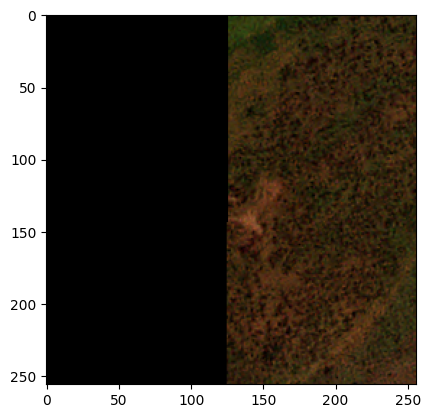

In [6]:
import matplotlib.pyplot as plt

with rio.open(f'{output2}/0001.png') as src :
    img = src.read((1,2,3))
    print(img.shape)
    img = np.transpose(img, (1, 2, 0))
    print(img.shape)

    plt.imshow(img)
